In [99]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
import warnings 
warnings.filterwarnings('ignore')
import lightgbm as lgb #LightGBM
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import joblib

import lightgbm as lgb

import sklearn.metrics


In [100]:
test_data = pd.read_json('datasets/rcqa/test.jsonl', orient='records', lines=True)
#test_data = pd.read_json('datasets/rcqa/val.jsonl', orient='records', lines=True)
test_data.head()

,qid,competition,timestamp,format,question,answer,title,text,score,did
0,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,ランウェイ,ランウェイ (runway) あるいはキャットウォーク (catwalk) とは、ファッショ...,4,1
1,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,Prism Stone,2012年3月30日、パシフィコ横浜で行われたタカラトミー主催のイベント「プリティーガールズ...,1,2
2,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,仙台コレクション,屋内で開催される同種のリアル・クローズのファッションショーで見られる出展ブランドの特設直販ブ...,0,3
3,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,ファッションショー,ファッションショーでは、予め選ばれたモデルが売り手側が用意した服を着て、観客席に挟まれた細長...,4,4
4,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,マンチカン,体長より少しばかり短い、動作豊かな尻尾を持つ。片足をもう一方の足と同じ直線上に置きつつ、尻尾...,0,5


In [135]:
dataset = {}
for name in ['train', 'val', 'test']:
    x1 = joblib.load(f'datasets/rcqa/{name}_qa_emb.npy.pickle')
    x2 = joblib.load(f'datasets/rcqa/{name}_passage_emb.npy.pickle')

    cos_simil = np.squeeze(np.array([sklearn.metrics.pairwise.cosine_similarity([i1], [i2]) for i1, i2 in zip(x1, x2)]), axis=1)
    y = joblib.load(f'datasets/rcqa/{name}_rcqa_score.npy.pickle')

    X = np.concatenate([x1, x2, cos_simil], axis=1)
    del x1, x2

    dataset[name] = {
        'X': X,
        'y': y
    }

In [137]:
X_train, y_train = dataset['train']['X'], dataset['train']['y']
X_val, y_val = dataset['val']['X'], dataset['val']['y']
X_test, y_test = dataset['test']['X'], dataset['test']['y']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((45371, 1537), (45371, 1), (5736, 1537), (5736, 1), (5544, 1537), (5544, 1))

In [138]:
from sklearn import utils

X_train, y_train = utils.shuffle(X_train, y_train)

In [139]:
model = lgb.LGBMRegressor() # モデルのインスタンスの作成
model.fit(X_train, y_train) # モデルの学習

# テストデータの予測
y_pred = model.predict(X_test)

In [140]:
mean_squared_error(y_test, y_pred)

2.37313513638963

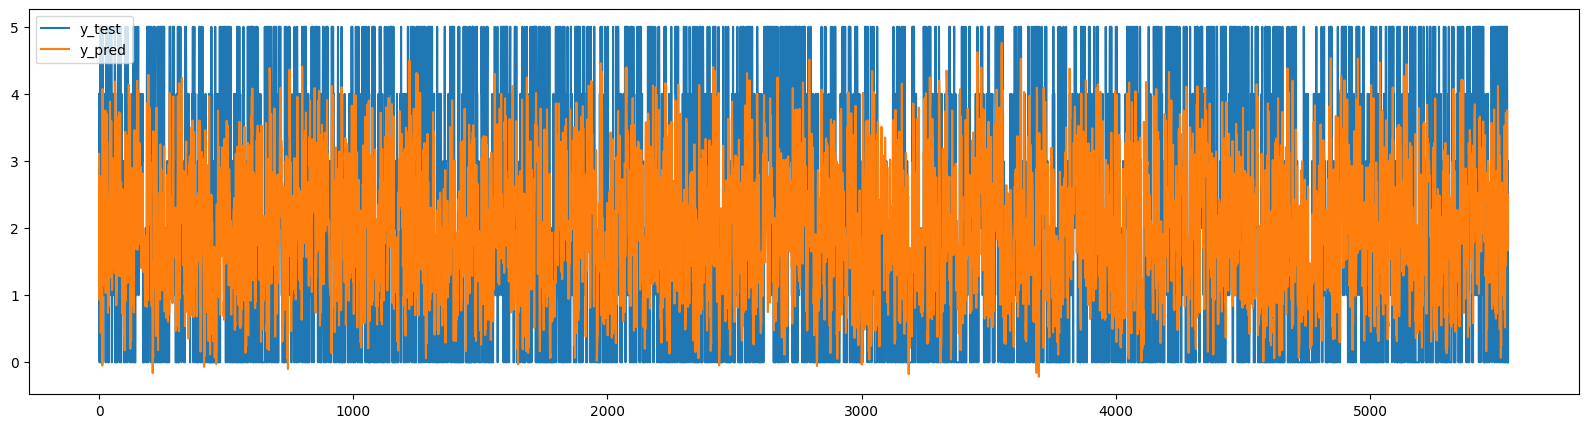

In [141]:
plt.figure(figsize=(20, 5))
plt.plot(y_test, label="y_test")
plt.plot(y_pred, label="y_pred")
plt.legend()


In [142]:
r2_score(y_test, y_pred)

0.3193905172000979

In [143]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'rmse'}, 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train,
                  valid_sets=lgb_eval,
                  num_boost_round=200
                  )

# テストデータの予測
y_pred = model.predict(X_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.424239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391935
[LightGBM] [Info] Number of data points in the train set: 45371, number of used features: 1537
[LightGBM] [Info] Start training from score 1.899958
[1]	valid_0's rmse: 1.82286
[2]	valid_0's rmse: 1.78655
[3]	valid_0's rmse: 1.75619
[4]	valid_0's rmse: 1.73117
[5]	valid_0's rmse: 1.71006
[6]	valid_0's rmse: 1.69276
[7]	valid_0's rmse: 1.67764
[8]	valid_0's rmse: 1.66447
[9]	valid_0's rmse: 1.65368
[10]	valid_0's rmse: 1.64478
[11]	valid_0's rmse: 1.63787
[12]	valid_0's rmse: 1.63164
[13]	valid_0's rmse: 1.62641
[14]	valid_0's rmse: 1.62104
[15]	valid_0's rmse: 1.61691
[16]	valid_0's rmse: 1.61337
[17]	valid_0's rmse: 1.61011
[18]	valid_0's rmse: 1.60666
[19]	valid_0's rmse: 1.60421
[20]	valid_0's rmse: 1.60168
[21]	valid_0's rmse: 1.59959
[22]	valid_0's rmse: 1.59797
[23]	valid_0's rmse: 1

In [144]:
mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

(2.325086267388447, 0.3331708179417435)

Text(0.5, 0, 'y (RCQA score)')

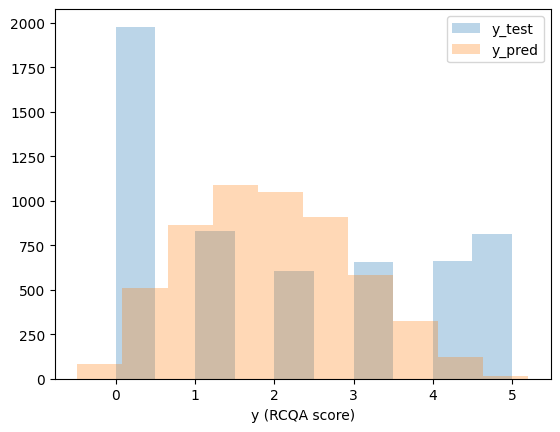

In [145]:
plt.hist(y_test, alpha=0.3, label='y_test')
plt.hist(y_pred, alpha=0.3, label='y_pred')
plt.legend();
plt.xlabel('y (RCQA score)')